In [39]:
from datetime import datetime
import numpy as np
import torch
import random
import torch.nn as nn

import pickle
import argparse
from data import DATA
import json
import os
from optimizer import OPTIM
from logger import LOGGER
from collections import Counter

import time
from train import TRAINER
from model import MF
from eval import EVAL
from metric import get_recall
import matplotlib.pyplot as plt

In [3]:
parser = argparse.ArgumentParser()

### data
parser.add_argument('--data_dir', type=str, default='data')
parser.add_argument('--data_name', type=str, default='movielens')
parser.add_argument('--data_file', type=str, default='data.pickle')

parser.add_argument('--vocab_file', type=str, default='vocab.json')
parser.add_argument('--model_file', type=str, default="model_best.pt")
parser.add_argument('--model_name', type=str, default="MF")
parser.add_argument('--model_path', type=str, default="../checkpoint/")

### model
parser.add_argument('--user_emb_size', type=int, default=300)
parser.add_argument('--item_emb_size', type=int, default=300)

parser.add_argument('--output_hidden_size', type=int, default=300)

### train
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--optimizer', type=str, default='Adam')
parser.add_argument('--weight_decay', type=float, default=0.0)
parser.add_argument('--l2_reg', type=float, default=0.0)

parser.add_argument('--learning_rate', type=float, default=0.0001)
parser.add_argument('--momentum', type=float, default=0.99)
parser.add_argument('--epoch_num', type=int, default=10)
parser.add_argument('--print_interval', type=int, default=200)
parser.add_argument('--hcdmg1', action="store_true", default=False)

### hyper-param
# parser.add_argument('--init_mult', type=float, default=1.0)
# parser.add_argument('--variance', type=float, default=0.995)
# parser.add_argument('--max_seq_length', type=int, default=100)

### others
parser.add_argument('--train', action='store_true', default=False)
parser.add_argument('--test', action='store_true', default=False)
parser.add_argument('--eval', action='store_true', default=False)
parser.add_argument('--parallel', action="store_true", default=False)
parser.add_argument('--local_rank', type=int, default=0)

args = parser.parse_args([])


In [4]:
# CUDA_VISIBLE_DEVICES=1 python main.py --data_dir "../data/ml-25m" \
# --data_name "movie" --model_file "movie_MF/model_best_2_16_16_28.pt" \
# --vocab_file "vocab.json" --eval --batch_size 8 --user_emb_size 16 --item_emb_size 16

In [18]:
args.data_dir = "../data/ml-1m"
args.data_name = "movie"
args.model_file = "movie_MF/model_best_2_17_10_45.pt"
args.vocab_file = "vocab.json"
args.epoch_num = 50
args.batch_size = 32
args.learning_rate = 0.0001
args.user_emb_size = 128
args.item_emb_size = 128
args.weight_decay = 0.0

In [19]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [20]:
ts = time.strftime('%Y-%b-%d-%H:%M:%S', time.gmtime())
seed = 1234
set_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda


In [21]:
# local_rank = None
# if args.parallel:
#     local_rank = args.local_rank
#     torch.distributed.init_process_group(backend="nccl")
#     device = torch.device('cuda:{}'.format(local_rank))

data_obj = DATA()

if "movie" in args.data_name:
    print("data_name", args.data_name)
    train_data, valid_data, test_data, vocab_obj = data_obj.f_load_movie(args)


data
data_name movie
train user num 5949
train item num 2810
sample num 454860
batch num 14214
... load train data ... 454860 454860
sample num 56864
batch num 1777
unique_user_num 5949
user num unique in df 5949
... load train data ... 5949 5949
sample num 59807
batch num 1868
unique_user_num 5949
user num unique in df 5949
... load train data ... 5949 5949


In [22]:


# print("vocab_size", vocab_obj.vocab_size)
print("user num", vocab_obj.user_num)
print("item num", vocab_obj.item_num)

network = MF(vocab_obj, args, device)

user num 5950
item num 2811


In [23]:
total_param_num = 0
for name, param in network.named_parameters():
    if param.requires_grad:
        param_num = param.numel()
        total_param_num += param_num
        print(name, "\t", param_num)

print("total parameters num", total_param_num)


m_user_embed.weight 	 761600
m_item_embed.weight 	 359808
total parameters num 1121408


In [24]:
eval_obj = EVAL(vocab_obj, args, device)
network = network.to(device)

In [27]:
def f_init_eval(network, model_file=None, reload_model=False):
    if reload_model:
        print("reload model")
        if not model_file:
            model_file = "model_best.pt"
        model_name = os.path.join(model_path, model_file)
        print("model name", model_name)
        check_point = torch.load(model_name)
        network.load_state_dict(check_point['model'])

    return network

In [28]:
model_path = args.model_path
print("model_path", model_path)
network = f_init_eval(network, model_file=args.model_file, reload_model=True)

model_path ../checkpoint/
reload model
model name ../checkpoint/movie_MF/model_best_2_17_10_45.pt


In [122]:
def f_eval_new(eval_data):

    recall_list = []

    print('--'*10)

    topk = 20
    network.eval()
    with torch.no_grad():

        for user_batch, item_batch, mask_item_batch, \
            itemnum_batch in eval_data:

            user_gpu = user_batch.to(device)

            logits = network.f_eval_forward(user_gpu)

            recall = get_recall(logits.cpu(), item_batch, mask_item_batch, \
                                itemnum_batch, k=topk)

            recall_list.append(recall)

    mean_recall = np.mean(recall_list)
    print("recall@%d:%.4f"%(topk, mean_recall))

In [323]:
f_eval_new(valid_data)

--------------------
recall@20:0.2635


In [324]:
f_eval_new(test_data)

--------------------
recall@20:0.2569


item num 2810
min freq: 5, max freq: 2245


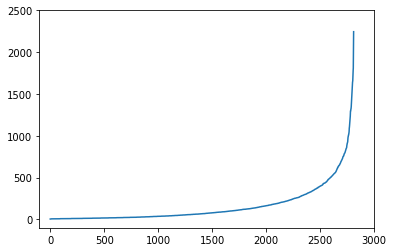

In [138]:
def visualize_item_freq(data):
    item_freq_dict = dict(Counter(data.dataset.m_pos_item_batch_list))
    item_num = len(item_freq_dict)
    print("item num", item_num)
    freq_list = list(item_freq_dict.values())
    print("min freq: %d, max freq: %d"%(min(freq_list), max(freq_list)))
    
    x = [i for i in range(item_num)]
    y = sorted(freq_list)
    
#     plt.xscale("log")
#     plt.yscale("log")
    plt.plot(x, y)

    plt.xlim([-100, 3000])
    plt.ylim([-100, 2500])
    plt.show()

visualize_item_freq(train_data)

In [75]:
print(454860/6)
print([i for i in range(0, 10, 1)])

75810.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


75810.0


item num 2810
min freq: 5, max freq: 2245
cumsum_y [     5     10     15 ... 450551 452615 454860]


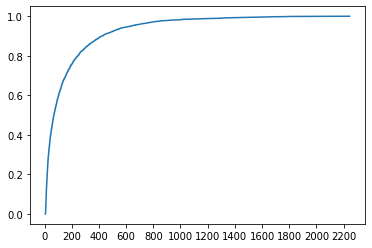

In [139]:
def visualize_item_freq(data):
    item_freq_dict = dict(Counter(data.dataset.m_pos_item_batch_list))
    item_num = len(item_freq_dict)
    print("item num", item_num)
    freq_list = list(item_freq_dict.values())
    print("min freq: %d, max freq: %d"%(min(freq_list), max(freq_list)))
    
    x = [i for i in range(item_num)]
    y = sorted(freq_list)
    cumsum_y = np.cumsum(y)
    print("cumsum_y", cumsum_y)
    
    p = 1.0*np.arange(len(y))/(len(y)-1)
    
    for i in range(item_num):
        p_i = p[i]
        y_i = y[i]
        cumsum_y_i = cumsum_y[i]
        
#         if cumsum_y_i > 379050:
#             print(i, y_i)
#         elif cumsum_y_i > 303240:
#             print(i, y_i)
#         elif cumsum_y_i > 227430:
#             print(i, y_i)
#         elif cumsum_y_i > 151620:
#             print(i, y_i)
#         elif cumsum_y_i > 75810:
#             print(i, y_i)
        
#     plt.plot(x, y)
    plt.xticks([i for i in range(0, 2250, 200)])
    plt.plot(y, p)
    

#     plt.xlim([-100, 3000])
#     plt.ylim([-100, 2500])
    plt.show()

visualize_item_freq(train_data)

In [140]:
gap = 454860//6
print(gap)
cumsum_freq_threshold_list = [int(i) for i in range(0, 454860, gap)]
print(cumsum_freq_threshold_list)
print(len(cumsum_freq_threshold_list))

75810
[0, 75810, 151620, 227430, 303240, 379050]
6


In [162]:
def set_bucket4item(data):
    item_freq_dict = dict(Counter(data.dataset.m_pos_item_batch_list))
    print("item num", len(item_freq_dict))
    freq_list = list(item_freq_dict.values())
    print("min freq: %d, max freq: %d"%(min(freq_list), max(freq_list)))
#     freq_threshold_list = [0, 20, 80, 150, 200, 250, 300, 350]
#     freq_threshold_list = [0, 100, 200, 400, 600, 1000]
#     cumsum_freq_threshold_list = []

    itemid_bucketid_dict = {}
    bucketid_itemidlist_dict = {}
    
    sorted_item_freq_dict = {k:v for k, v in sorted(item_freq_dict.items(), key=lambda x: x[1])}
    
    cumsum_i = 0
    for itemid in sorted_item_freq_dict:
        i = item_freq_dict[itemid]
        cumsum_i += i
        
        bucketid = 0
        if cumsum_i <= cumsum_freq_threshold_list[1]:
            bucketid = 1
        elif cumsum_i <= cumsum_freq_threshold_list[2]:
            bucketid = 2
        elif cumsum_i <= cumsum_freq_threshold_list[3]:
            bucketid = 3
        elif cumsum_i <= cumsum_freq_threshold_list[4]:
            bucketid = 4
        elif cumsum_i <= cumsum_freq_threshold_list[5]:
            bucketid = 5
#         elif i <= freq_threshold_list[6]:
#             bucketid = 6
#         elif i <= freq_threshold_list[7]:
#             bucketid = 7
        else:
            bucketid = 6
        itemid_bucketid_dict[itemid] = bucketid
        if bucketid not in bucketid_itemidlist_dict:
            bucketid_itemidlist_dict[bucketid] = []
        bucketid_itemidlist_dict[bucketid].append(itemid)

    print("bucket", len(bucketid_itemidlist_dict), bucketid_itemidlist_dict.keys())
#     for bucketid in bucketid_itemidlist_dict:
    for bucketid in range(1, len(bucketid_itemidlist_dict)+1):
        itemid_list_bucket = bucketid_itemidlist_dict[bucketid]
        freq_bucket = 0
        freq_list_bucket = []
        for itemid in itemid_list_bucket:
            itemfreq_i = item_freq_dict[itemid]
            freq_list_bucket.append(itemfreq_i)
            freq_bucket += itemfreq_i
        print("bucket %d, freq: %d, item num: %d"%(bucketid, freq_bucket, len(itemid_list_bucket)))
        print("[min, max]: [%d, %d]"%(min(freq_list_bucket), max(freq_list_bucket)))
    return item_freq_dict, itemid_bucketid_dict, bucketid_itemidlist_dict


In [163]:
train_item_freq_dict, train_itemid_bucketid_dict, train_bucketid_itemidlist_dict = \
    set_bucket4item(train_data)

item num 2810
min freq: 5, max freq: 2245
bucket 6 dict_keys([1, 2, 3, 4, 5, 6])
bucket 1, freq: 75754, item num: 1798
[min, max]: [5, 121]
bucket 2, freq: 75809, item num: 441
[min, max]: [122, 239]
bucket 3, freq: 75578, item num: 248
[min, max]: [241, 387]
bucket 4, freq: 75762, item num: 161
[min, max]: [388, 575]
bucket 5, freq: 75970, item num: 105
[min, max]: [582, 918]
bucket 6, freq: 75987, item num: 57
[min, max]: [924, 2245]


In [143]:
def bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 20
    
    item_recall_dict = {}
    item_mrr_dict = {}
#     # ### load 
    # item_freq_dict = {}

    with torch.no_grad():
        total_test_num = []

        for user_batch, item_batch, mask_item_batch, itemnum_batch in eval_data:
            
            user_batch_gpu = user_batch.to(device)
            loss = 0.0

            logits = network.f_eval_forward(user_batch_gpu)
                
            preds = logits.cpu()
            preds.scatter_(1, mask_item_batch, float("-inf"))
            preds[:, 0] = float("-inf")
            
            _, preds = torch.topk(preds, topk, -1)
            
#             print(user_batch.size())
#             print(item_batch.size())
            targets = item_batch
        
            batch_size = preds.size(0)
        
            for i in range(batch_size):
                pred_i = list(preds[i].numpy())
                target_i = targets[i].numpy()
                
                itemnum_i = itemnum_batch[i].item()
                
                target_i = list(target_i)[:itemnum_i]
                
                for j in range(itemnum_i):
                    target_ij = target_i[j]
                    if target_ij not in item_recall_dict:
                        item_recall_dict[target_ij] = []
                    
                    if target_ij in pred_i:
                        item_recall_dict[target_ij].append(1.0)
                    else:
                        item_recall_dict[target_ij].append(0.0)
                        
    return item_recall_dict, item_mrr_dict  

In [149]:
test_item_recall_dict, test_item_mrr_dict = bias_eval(test_data, train_itemid_bucketid_dict)

In [153]:
bucket_recall_dict = {}
for item in test_item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(test_item_recall_dict[item])
    
#     item_recall = item_recall[0]*1.0/item_recall[1]
    if bucketid not in bucket_recall_dict:
        bucket_recall_dict[bucketid] = []
        bucket_mrr_dict[bucketid] = []
    bucket_recall_dict[bucketid].append(item_recall)

for bucket in bucket_recall_dict:
    recall_list = bucket_recall_dict[bucket]
    mean_recall = np.mean(recall_list)
    bucket_recall_dict[bucket] = mean_recall


In [154]:
print("recall")
for i in range(1, len(bucket_recall_dict)+1):
    print("%d:%.4f"%(i, bucket_recall_dict[i]), end=", ")
print()

recall
1:0.0089, 2:0.0539, 3:0.1208, 4:0.1890, 5:0.2836, 6:0.4767, 


In [155]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

### @20

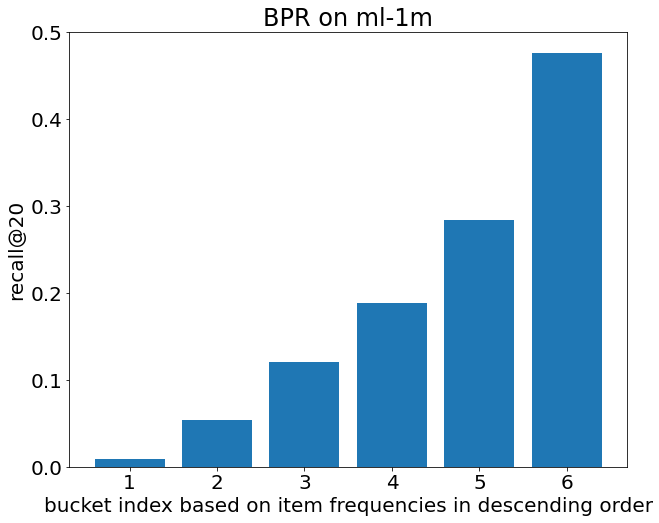

In [159]:

plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 20

# cdf = 1.0*np.arange(len(y))/(len(y)-1)
# plt.plot(y, cdf, linewidth=3)
# plt.plot(103, 0.8, "o", label="(100, 0.8)", markersize=8)
# plt.ylabel("cumulative distribution of user num")
# plt.xlabel("number of interactions per user")


x = [i for i in range(1, len(bucket_recall_dict)+1)]
recall_list = [bucket_recall_dict[i] for i in range(1, len(bucket_recall_dict)+1)]
plt.bar(x, recall_list)
plt.xlabel("bucket index based on item frequencies in descending order")
plt.ylabel("recall@20")
plt.title("BPR on ml-1m")

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# plt.legend(loc="right")
plt.show()

plt.show()

### calibrated

In [ ]:
from scipy import stats
import math

In [166]:
item_num = vocab_obj.item_num
print("item num", item_num)

user_num = vocab_obj.user_num
print("user num", user_num)

item num 2811
user num 5950


In [170]:
print("item num", len(train_item_freq_list))

item num 2811


In [168]:
train_item_freq_list = [train_item_freq_dict[i] if i in train_item_freq_dict else 0.0 for i in range(item_num)]
item_pop = torch.from_numpy(np.array(train_item_freq_list)).to(device)
item_pop = item_pop+1e-20
print("item pop size", item_pop.size())

item pop size torch.Size([2811])


In [509]:
beta = 0.2
def compensation(logits):
    logits = logits*beta+(1-beta)
    
    com_logits = logits/item_pop.unsqueeze(0)
    
    return com_logits

In [510]:
alpha = 1.4
def compensated_score(logits, mask_item):
    com_logits = compensation(logits)
    
    com_logits[:, 0] = 0
    
    logits.scatter_(1, mask_item, 0.0)
    com_logits.scatter_(1, mask_item, 0.0)
    
    true_mask = (mask_item != 0).float()
    true_num_mask = torch.sum(true_mask, dim=-1, keepdim=True)
    mask_item_num = item_num-1-true_num_mask
    
    n_u = torch.norm(logits/mask_item_num, dim=-1, keepdim=True)
    m_u = torch.norm(com_logits/mask_item_num, dim=-1, keepdim=True)
    
#     print("logits", logits)
#     print("com_logits", com_logits)
    
#     print("n_u", n_u)
#     print("m_u", m_u)
    
    tmp = alpha*com_logits*n_u/m_u
    score = logits+tmp
    
    return score

In [511]:
item_num

2811

### user side

In [512]:
def compensated_bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 20
    
    item_recall_dict = {}
    item_mrr_dict = {}

    iter_index = 0
    
    pru_list = []
  
    ### user: [item_rank]
    user_itemrank_dict = {}
    user_itempop_dict = {}
    
    with torch.no_grad():
        total_test_num = []

        for user_batch, item_batch, mask_item_batch, itemnum_batch in eval_data:
            
            user_batch_gpu = user_batch.to(device)
            mask_item_batch_gpu = mask_item_batch.to(device)
            
            loss = 0.0

            logits = network.f_eval_forward(user_batch_gpu)
            
            compensated_logits = compensated_score(logits, mask_item_batch_gpu)
            
            preds = compensated_logits.cpu()
            preds.scatter_(1, mask_item_batch, float("-inf"))
            preds[:, 0] = float("-inf")
            
            _, rank = torch.topk(preds, item_num, -1)
            
            _, topk_preds = torch.topk(preds, topk, -1)
            

            targets = item_batch
        
            batch_size = topk_preds.size(0)
        
            for i in range(batch_size):
                target_rank_i = []
                target_pop_i = []
                
                user_i = user_batch[i].item()
                
                rank_i = list(rank[i].numpy())
                topk_pred_i = list(topk_preds[i].numpy())
                target_i = targets[i].numpy()
                
                itemnum_i = itemnum_batch[i].item()
                
                target_i = list(target_i)[:itemnum_i]
                
                for j in range(itemnum_i):
                    target_ij = target_i[j]
                    
                    target_pop_ij = train_item_freq_dict[target_ij]
                    target_pop_i.append(target_pop_ij)
                    
                    target_rank_ij = rank_i.index(target_ij)
                    target_rank_i.append(target_rank_ij)
                    
                user_itemrank_dict[user_i] = target_rank_i
                user_itempop_dict[user_i] = target_pop_i

    return user_itemrank_dict, user_itempop_dict

In [513]:
test_user_itemrank_dict, test_user_itempop_dict = compensated_bias_eval(test_data, train_itemid_bucketid_dict)

In [514]:
### pru

pru_list = []
for user in test_user_itemrank_dict:
    user_itemrank_i = test_user_itemrank_dict[user]
    user_itempop_i = test_user_itempop_dict[user]
    pru_i = 1.0
    if len(user_itemrank_i) > 1:
        pru_i = stats.spearmanr(user_itempop_i, user_itemrank_i)[0]
    pru_list.append(pru_i)
pru = np.mean(pru_list)
pru = -pru
print("user num", len(pru_list), "PRU:%.4f"%pru)

user num 5949 PRU:0.3638


In [515]:
def compensated_bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 20
    

    iter_index = 0
    
    recall_list = []
    
    with torch.no_grad():
        total_test_num = []

        for user_batch, item_batch, mask_item_batch, itemnum_batch in eval_data:
            
            user_batch_gpu = user_batch.to(device)
            mask_item_batch_gpu = mask_item_batch.to(device)
            
            loss = 0.0

            logits = network.f_eval_forward(user_batch_gpu)
            
            compensated_logits = compensated_score(logits, mask_item_batch_gpu)
            
            preds = compensated_logits.cpu()
            preds.scatter_(1, mask_item_batch, float("-inf"))
            preds[:, 0] = float("-inf")
                        
            _, topk_preds = torch.topk(preds, topk, -1)
            
            targets = item_batch
        
            batch_size = topk_preds.size(0)
        
            for i in range(batch_size):
                target_rank_i = []
                target_pop_i = []
                
                user_i = user_batch[i].item()
                
                topk_pred_i = list(topk_preds[i].numpy())
                target_i = targets[i].numpy()
                
                itemnum_i = itemnum_batch[i].item()
                
                target_i = list(target_i)[:itemnum_i]
                
                correctnum_i = 0
                
                for j in range(itemnum_i):
                    target_ij = target_i[j]
                    
                    if target_ij in topk_pred_i:
                        correctnum_i += 1.0
                    
                recall_i = correctnum_i/itemnum_i
                recall_list.append(recall_i)
                    
    return recall_list

In [516]:
recall_list = compensated_bias_eval(test_data, train_itemid_bucketid_dict)

In [517]:
mean_recall = np.mean(recall_list)
print("recall: %.4f"%mean_recall, len(recall_list))

recall: 0.2079 5949


### item side

In [518]:
def compensated_bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 20
    
    item_recall_dict = {}
    item_mrr_dict = {}
#     # ### load 
    # item_freq_dict = {}

    iter_index = 0
    
    ## {item: rank}
    item_rank_dict = {}

    with torch.no_grad():
        total_test_num = []

        for user_batch, item_batch, mask_item_batch, itemnum_batch in eval_data:
            
            user_batch_gpu = user_batch.to(device)
            mask_item_batch_gpu = mask_item_batch.to(device)
            
            loss = 0.0

            logits = network.f_eval_forward(user_batch_gpu)
            
            compensated_logits = compensated_score(logits, mask_item_batch_gpu)
            
            preds = compensated_logits.cpu()
            preds.scatter_(1, mask_item_batch, float("-inf"))
            preds[:, 0] = float("-inf")
            
            _, rank = torch.topk(preds, item_num, -1)
                        
#             if iter_index > 1:
#                 break
#             iter_index += 1
                
            targets = item_batch
        
            batch_size = preds.size(0)
        
            for i in range(batch_size):
               
                rank_i = list(rank[i].numpy())
                target_i = targets[i].numpy()
                
                itemnum_i = itemnum_batch[i].item()
                
                target_i = list(target_i)[:itemnum_i]
                
                for j in range(itemnum_i):
                    target_ij = target_i[j]
                
                    target_rank_ij = rank_i.index(target_ij)
                    
                    if target_ij not in item_rank_dict:
                        item_rank_dict[target_ij] = []
                    item_rank_dict[target_ij].append(target_rank_ij)
        
    return item_rank_dict 

In [519]:
test_item_rank_dict = compensated_bias_eval(test_data, train_itemid_bucketid_dict)

In [520]:
### get pri
item_pop_list_pri = []
item_rank_list_pri = []
for item in test_item_rank_dict:
    item_avgrank_i = np.mean(test_item_rank_dict[item])
    item_rank_list_pri.append(item_avgrank_i)
    
    item_pop_i = train_item_freq_dict[item]
    item_pop_list_pri.append(item_pop_i)
    
pri = stats.spearmanr(item_pop_list_pri, item_rank_list_pri)[0]
pri = -pri
print("pri: %.4f"%pri)

pri: 0.7238


In [475]:
### item recall

In [521]:
def compensated_bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 20
    
    item_recall_dict = {}
    item_mrr_dict = {}
#     # ### load 
    # item_freq_dict = {}

    iter_index = 0
    
    with torch.no_grad():
        total_test_num = []

        for user_batch, item_batch, mask_item_batch, itemnum_batch in eval_data:
            
            user_batch_gpu = user_batch.to(device)
            mask_item_batch_gpu = mask_item_batch.to(device)
            
            loss = 0.0

            logits = network.f_eval_forward(user_batch_gpu)
            
            compensated_logits = compensated_score(logits, mask_item_batch_gpu)
            
            preds = compensated_logits.cpu()
            preds.scatter_(1, mask_item_batch, float("-inf"))
            preds[:, 0] = float("-inf")
                        
            _, topk_preds = torch.topk(preds, topk, -1)
                
            targets = item_batch
        
            batch_size = topk_preds.size(0)
        
            for i in range(batch_size):
               
                topk_pred_i = list(topk_preds[i].numpy())
                target_i = targets[i].numpy()
                
                itemnum_i = itemnum_batch[i].item()
                
                target_i = list(target_i)[:itemnum_i]
                
                for j in range(itemnum_i):
                    target_ij = target_i[j]
                    
                    if target_ij not in item_recall_dict:
                        item_recall_dict[target_ij] = []
                    
                    if target_ij in topk_pred_i:
                        item_recall_dict[target_ij].append(1.0)
                    else:
                        item_recall_dict[target_ij].append(0.0)
                    
    
    return item_recall_dict

In [522]:
test_item_recall_dict = compensated_bias_eval(test_data, train_itemid_bucketid_dict)

In [523]:
total_recall_list = []
bucket_recall_dict = {}
bucket_size_dict = {}
for item in test_item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(test_item_recall_dict[item])
    
#     item_recall = item_recall[0]*1.0/item_recall[1]
    if bucketid not in bucket_recall_dict:
        bucket_recall_dict[bucketid] = []
        
    bucket_recall_dict[bucketid].append(item_recall)
    total_recall_list.append(item_recall)

for bucket in bucket_recall_dict:
    bucket_recall_list = bucket_recall_dict[bucket]
    bucket_size_dict[bucket] = len(bucket_recall_list)
    mean_recall = np.mean(bucket_recall_list)
    bucket_recall_dict[bucket] = mean_recall


In [524]:
print("recall")
for i in range(1, len(bucket_recall_dict)+1):
    print("%d:%.4f:%d"%(i, bucket_recall_dict[i], bucket_size_dict[i]), end=", ")
print()
print("mean recall: %.4f"%np.mean(total_recall_list), len(total_recall_list))

recall
1:0.0595:1689, 2:0.0491:441, 3:0.0859:248, 4:0.1348:161, 5:0.2064:105, 6:0.3772:57, 
mean recall: 0.0771 2701


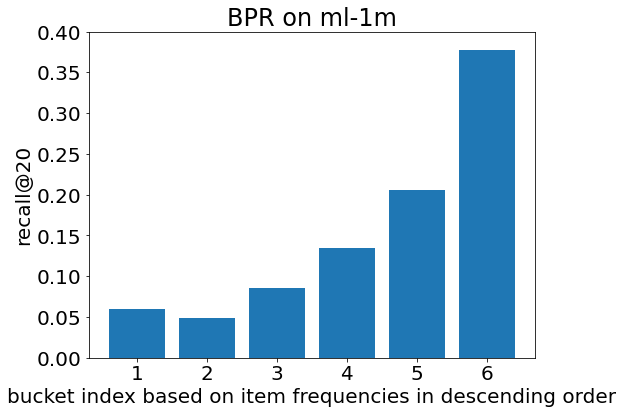

In [526]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 20

x = [i for i in range(1, len(bucket_recall_dict)+1)]
recall_list = [bucket_recall_dict[i] for i in range(1, len(bucket_recall_dict)+1)]
plt.bar(x, recall_list)
plt.ylim([0, 0.40])
plt.xlabel("bucket index based on item frequencies in descending order")
plt.ylabel("recall@20")
plt.title("BPR on ml-1m")

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# plt.legend(loc="right")
plt.show()

plt.show()

In [318]:
def compensated_bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 20
    
    item_recall_dict = {}
    item_mrr_dict = {}
#     # ### load 
    # item_freq_dict = {}

    iter_index = 0
    
    pru_list = []
    pri_list = []
    
    ## {item: rank}
    item_rank_dict = {}
    user_itemrank_dict = {}
    user_itempop_dict = {}
    
    with torch.no_grad():
        total_test_num = []

        for user_batch, item_batch, mask_item_batch, itemnum_batch in eval_data:
            
            user_batch_gpu = user_batch.to(device)
            mask_item_batch_gpu = mask_item_batch.to(device)
            
            loss = 0.0

            logits = network.f_eval_forward(user_batch_gpu)
            
            compensated_logits = compensated_score(logits, mask_item_batch_gpu)
            
            preds = compensated_logits.cpu()
            preds.scatter_(1, mask_item_batch, float("-inf"))
            preds[:, 0] = float("-inf")
            
            _, rank = torch.topk(preds, item_num, -1)
            
            _, topk_preds = torch.topk(preds, topk, -1)
            
#             if iter_index > 1:
#                 break
#             iter_index += 1
                
            targets = item_batch
        
            batch_size = topk_preds.size(0)
        
            for i in range(batch_size):
                target_rank_i = []
                target_pop_i = []
                
                rank_i = list(rank[i].numpy())
                topk_pred_i = list(topk_preds[i].numpy())
                target_i = targets[i].numpy()
                
                itemnum_i = itemnum_batch[i].item()
                
                target_i = list(target_i)[:itemnum_i]
                
                for j in range(itemnum_i):
                    target_ij = target_i[j]
                    
                    target_pop_ij = train_item_freq_dict[target_ij]
                    target_pop_i.append(target_pop_ij)
                    
                    target_rank_ij = rank_i.index(target_ij)
                    target_rank_i.append(target_rank_ij)
                    
                    if target_ij not in item_recall_dict:
                        item_recall_dict[target_ij] = []
                    
                    if target_ij in topk_pred_i:
                        item_recall_dict[target_ij].append(1.0)
                    else:
                        item_recall_dict[target_ij].append(0.0)
                    
                    if target_ij not in item_rank_dict:
                        item_rank_dict[target_ij] = []
                    item_rank_dict[target_ij].append(target_rank_ij)
                
                pru_i = 1.0
                if len(target_pop_i) > 1:
                    pru_i = stats.spearmanr(target_pop_i, target_rank_i)[0]
#                 
                if math.isnan(pru_i):
                    print("=="*10)
                    print("pru", pru_i)
                    print("target_pop_i", target_pop_i)
                    print("target_rank_i", target_rank_i)
                pru_list.append(pru_i)
    
    mean_pru = -np.mean(pru_list)
    print("pru", mean_pru, len(pru_list))
    
    return item_recall_dict, item_mrr_dict, item_rank_dict 

In [319]:
test_item_recall_dict, test_item_mrr_dict, test_item_rank_dict = compensated_bias_eval(test_data, train_itemid_bucketid_dict)

pru 0.555028849285561 5949


In [322]:
### get pri
item_pop_list_pri = []
item_rank_list_pri = []
for item in test_item_rank_dict:
    item_avgrank_i = np.mean(test_item_rank_dict[item])
    item_rank_list_pri.append(item_avgrank_i)
    
    item_pop_i = train_item_freq_dict[item]
    item_pop_list_pri.append(item_pop_i)
    
pri = stats.spearmanr(item_pop_list_pri, item_rank_list_pri)[0]
pri = -pri
print("pri", pri)

pri 0.9295396010459206


In [316]:
total_recall_list = []
bucket_recall_dict = {}
bucket_size_dict = {}
for item in test_item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(test_item_recall_dict[item])
    
#     item_recall = item_recall[0]*1.0/item_recall[1]
    if bucketid not in bucket_recall_dict:
        bucket_recall_dict[bucketid] = []
        
    bucket_recall_dict[bucketid].append(item_recall)
    total_recall_list.append(item_recall)

for bucket in bucket_recall_dict:
    bucket_recall_list = bucket_recall_dict[bucket]
    bucket_size_dict[bucket] = len(bucket_recall_list)
    mean_recall = np.mean(bucket_recall_list)
    bucket_recall_dict[bucket] = mean_recall


In [309]:
print("recall")
for i in range(1, len(bucket_recall_dict)+1):
    print("%d:%.4f:%d"%(i, bucket_recall_dict[i], bucket_size_dict[i]), end=", ")
print()
print("mean recall: %.4f"%np.mean(total_recall_list), len(total_recall_list))

recall
1:0.0089:1689, 2:0.0539:441, 3:0.1208:248, 4:0.1890:161, 5:0.2836:105, 6:0.4767:57, 
mean recall: 0.1963 59807


In [317]:
print("recall")
for i in range(1, len(bucket_recall_dict)+1):
    print("%d:%.4f:%d"%(i, bucket_recall_dict[i], bucket_size_dict[i]), end=", ")
print()
print("mean recall: %.4f"%np.mean(total_recall_list), len(total_recall_list))

recall
1:0.0165:1689, 2:0.0519:441, 3:0.1186:248, 4:0.1866:161, 5:0.2830:105, 6:0.4769:57, 
mean recall: 0.0619 2701


In [314]:
print("recall")
for i in range(1, len(bucket_recall_dict)+1):
    print("%d:%.4f:%d"%(i, bucket_recall_dict[i], bucket_size_dict[i]), end=", ")
print()
print("mean recall: %.4f"%np.mean(total_recall_list), len(total_recall_list))

recall
1:0.0165:1689, 2:0.0519:441, 3:0.1186:248, 4:0.1866:161, 5:0.2830:105, 6:0.4769:57, 
mean recall: 0.1956 59807


### 1:0.0089, 2:0.0539, 3:0.1208, 4:0.1890, 5:0.2836, 6:0.4767, 

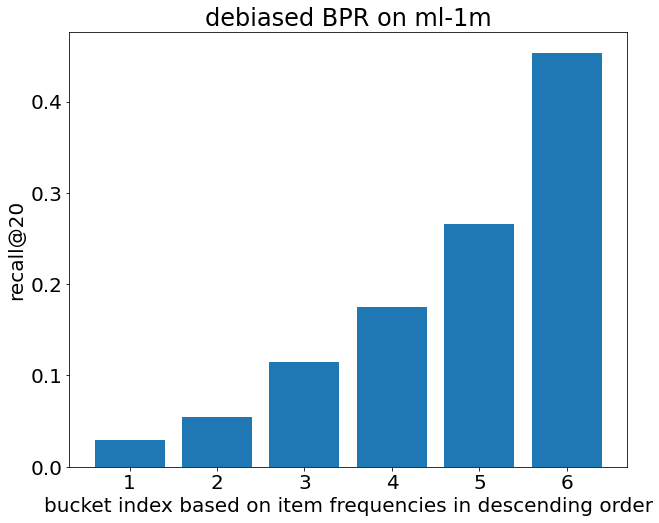

In [181]:
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 20

x = [i for i in range(1, len(bucket_recall_dict)+1)]
recall_list = [bucket_recall_dict[i] for i in range(1, len(bucket_recall_dict)+1)]
plt.bar(x, recall_list)
plt.xlabel("bucket index based on item frequencies in descending order")
plt.ylabel("recall@20")
plt.title("debiased BPR on ml-1m")

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# plt.legend(loc="right")
plt.show()

plt.show()